# Heat Transfer through a Window
This notebook produces plots for probability density functions of heat transfer through a window using Monte Carlo sampling and non-instrusive spectral projection (NISP) via full and sparse quadrature. It also produces a graph of the spectral decay of the polynomial chaos expansion coefficients.

In [1]:
# General imports
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')
from scipy import stats
from IPython.display import Image
import PyUQTk.pce as uqtkpce
import PyUQTk.PyPCE.pce_tools as pce_tools

# Problem-specific imports
from window_tools import *

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


## Setting input arguments

First, we set inputs arguments to define the kind of surrogate we will construct. 

We choose between three models:
1. Single-pane window with 6 or 7 uncertain parameters
2. Double-pane window with 4 or 5 uncertain parameters
3. Double-pane window with 8 or 12 uncertain parameters (Warning: the number of points produced increases drastically with an increase in order; nord < 4 is recommended.)

In [2]:
model = 1           # Which model to use
main_verbose = 0    # Set to 1 for intermediate print statements, otherwise set to 0
compute_rad = True  # Whether to include radiation calculations
nord = 3            # Order of the PCE
pc_type = "HG"      # Polynomial type (Note: 'HG' is currently the only option for the results are correct.)
pc_alpha = 0.0      # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0       # Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
param = nord +1     # Number of quadrature points per dimension for full quadrature or level for sparse quadrature
n_MC = 100000       # Number of random samples to use in evaluation

#### Model 1 inputs

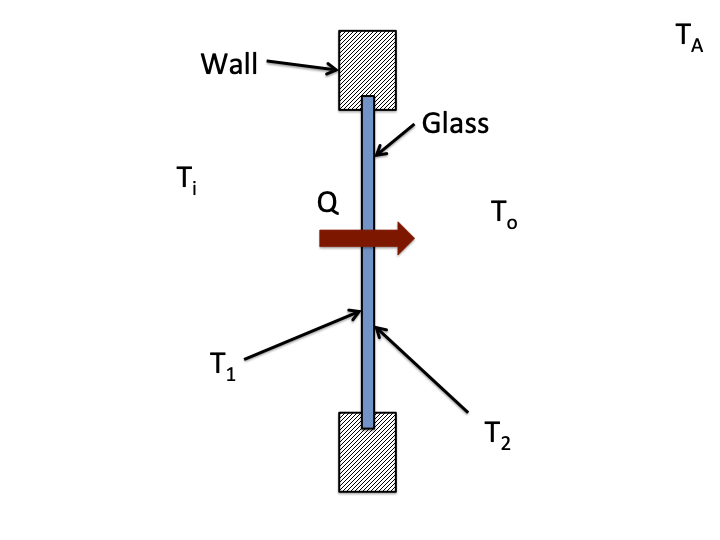

In [3]:
Image(filename = "img_window_1.png", width = 600, height = 300)

For model 1, we use the following forward model to calculate the heat flux Q through a single-pane window:
\begin{equation*}
Q= h_i(T_i-T_1)=k_w\frac{T_1-T_2}{d_w}=h_o(T_2-T_o)+ \epsilon\sigma(T_{2}^4-T_{A}^4)
\end{equation*}

We have the following constants:
 - $T_1$: Inner window temperature
 - $T_2$: Outer window temperature
 - $\epsilon$: Emissivity of uncoated glass
 - $\sigma$: Stefan-Boltzmann constant

We have six uncertain, Gaussian parameters (and add a seventh, $T_A$, if radiative heat transfer is considered). The parameters and their default means and standard deviations are defined below.

| Parameter | Mean | Standard deviation % |
| --- | --- | --- |
| $T_i$: Room temperature | 293 K | 0.5 |
| $T_o$: Outside temperature | 273 K | 0.5 |
| $d_w$: Window thickness | 0.01 m | 1 |
| $k_w$: Window conductivity | 1 $\frac{W}{mK}$ | 5 |
| $h_i$: Inner convective heat transfer coefficient | 2 $\mathrm{\frac{W}{m^2K}}$ | 15 |
| $h_o$: Outer convective heat transfer coefficient | 6 $\mathrm{\frac{W}{m^2K}}$ | 15 |
| $T_A$: Atmospheric temperature | 150 K | 10 |

In [4]:
if (model==1):
    
    # Mean values of the parameters
    Ti = 293.0 # Room temperature in K
    To = 273.0 # Outside temperature in K
    dw = 0.01  # Window thickness in m
    kw = 1.0   # Window conductivity in W/mK
    hi = 2.0   # Inner convective heat transfer coefficient in W/m^2K
    ho = 6.0   # Outer wall convective heat transfer coefficient in W/m^2K
    TA = 150.0 # Atmospheric temperature in K. Only used to calculate heat flux when it is assumed that radiative heat transfer occurs

    # Standard deviations of the Gaussian uncertainty of these parameters
    std_Ti=Ti*0.005
    std_To=To*0.005
    std_dw=dw*0.01
    std_kw=kw*0.05
    std_hi=hi*0.15
    std_ho=ho*0.15
    std_TA=TA*0.1
    
    # Create arrays of parameters
    p=[Ti,To,dw,kw,hi,ho]
    std_p=[std_Ti, std_To, std_dw, std_kw, std_hi, std_ho]
    if compute_rad:
        p.append(TA)
        std_p.append(std_TA)
        
    # Set number of dimensions of the PCE (number of uncertain variables)
    ndim=len(p)

#### Model 2 inputs

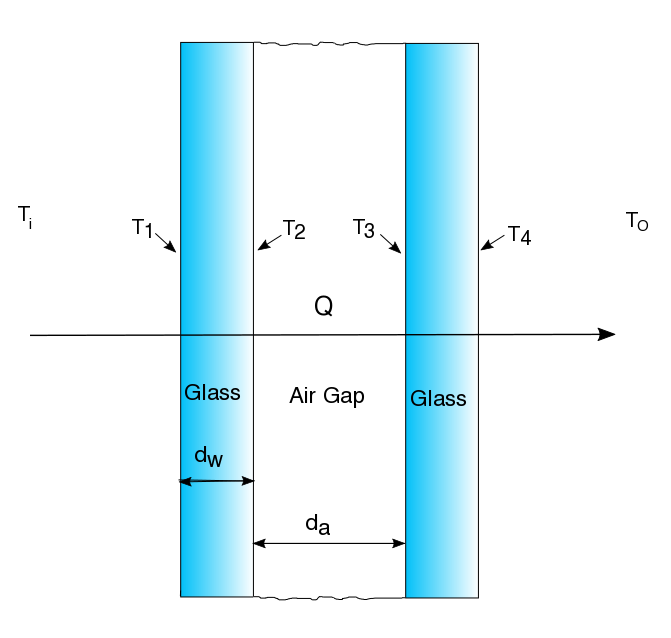

In [5]:
Image(filename = "img_window_2.png", width = 600, height = 300)

For model 2, we use the following forward model to calculate the heat flux Q through a dual-pane window:
\begin{align*}
Q&=h_i(T_i-T_1) = k_w\frac{T_1-T_2}{d_w} = 0.41\frac{k_a}{d_a}\left[\left(\frac{g\beta\rho^2{d_a}^3}{\mu^2}\right)|T_2-T_3|\right]^{0.16}(T_2-T_3) = k_w\frac{T_3-T_4}{d_w}\\
 &=h_o{(T_4-T_o)}+ \epsilon\sigma(T_{4}^4-T_{s}^4)
\end{align*}

This is similar to the steady state heat transfer equations of model 1 but adds the combined equation for conduction and convection for the air gap. This is defined as conductance and was implemented to provide an alternative to determining the convection coefficient for this region, which can be challenging [1].

We have the following constants:
 - $T_1$: Temperature of the outer facing surface for the first glass layer
 - $T_2$: Temperature of the inner surface for the first glass layer
 - $T_3$: Temperature of the inner surface of the second glass layer
 - $T_4$: Temperature the outer facing surface of the second glass layer
 - $\epsilon$: Emissivity of uncoated glass
 - $\sigma$: Stefan-Boltzmann constant
 - $d_w$: Width of the glass pane
 - $d_a$: Width of the gap between the panes
 - $T_i$: Room temperature 
 - $T_o$: Outside temperature
 - $g$: Acceleration due to gravity (for radiation and convection calculations)
 - $\mu$: Viscosity of air (for radiation and convection calculations)
 - $\rho$: Density of air (for radiation and convection calculations)
 - $\beta$: Coefficient of thermal exspansion (for radiation and convection calculations)

We have four uncertain, Gaussian parameters (and add a fifth, $T_s$, if radiation and convection are considered). The parameters and their default means and estimated standard deviations are defined below.

| Parameter | Mean | Standard deviation % |
| --- | --- | --- |
| $h_i$: Inside convection coefficient | 2 $\mathrm{\frac{W}{m^2K}}$ | 15 |
| $h_o$: Outside convection coefficient | 6 $\mathrm{\frac{W}{m^2K}}$ | 15 |
| $k_w$: Conduction constant for glass | 1 $\frac{W}{mK}$ | 5 |
| $k_a$: Conduction constant for air | 0.024 $\frac{W}{mK}$ | 5 |
| $T_s$: Sky Temperature [2] | 263 K | 10 |

[1] Rubin, Michael.Calculating Heat Transfer Through Windows. Energy Research. Vol. 6, pg 341-349. 1982.

[2] Leonard, John H. IV, Leinhard, John H. V. A Heat Transfer Textbook - 4th edition. pg 579. Phlogiston Press. 2011.

In [6]:
if (model==2):
    
    # Means of the uncertain, Gaussian parameters
    hi = 2.0   # Coefficient of convection inside (W/m^2*s)
    ho = 6.0   # Coefficient of convection outside (W/m^2*s)
    kw = 1.0   # Conduction constant for glass (W/m*K)
    ka = 0.024 # Conduction constant for air (W/m*K)
    Ts = 200.0 # Sky temperature (K)
    
    # Standard deviations of these uncertain parameters
    std_hi=hi*0.15
    std_ho=ho*0.15
    std_kw=kw*0.05
    std_ka=ka*0.05
    std_Ts=Ts*0.1
    
    # Create arrays of parameters
    p=[hi,ho,kw,ka] 
    std_p=[std_hi, std_ho, std_kw, std_ka]
    if compute_rad:
        p.append(Ts)
        std_p.append(std_Ts)
    
    # Set number of dimensions of the PCE (number of uncertain variables)
    ndim=len(p)

#### Model 3 inputs

For model 3, we use the same forward model as model 2 but change several of the constants to uncertain parameters. Without radiative heat transfer and convection, we use eight parameters, and with it, we use twelve, adding $T_s$, $\mu$, $\rho$, and $\beta$. All parameters used in this model and their default means and estimated standard deviations are defined below.

| Parameter | Mean | Standard deviation % |
| --- | --- | --- |
| $T_i$: Inside temperature | 293 K | 0.5 |
| $T_o$: Outside temperature | 273 K | 0.5 |
| $d_w$: Width of the glass | 5 mm | 1 |
| $d_a$: Width of the air gap | 1 cm | 1 |
| $k_w$: Conduction constant for glass | 1 $\frac{W}{mK}$ | 5 |
| $k_a$: Conduction constant for air | 0.024 $\frac{W}{mK}$ | 5 |
| $h_i$: Inside convection coefficient | 2 $\mathrm{\frac{W}{m^2K}}$ | 15 |
| $h_o$: Outside convection coefficient | 6 $\mathrm{\frac{W}{m^2K}}$ | 15 |
| $T_s$: Sky Temperature | 263 K | 10 |
| $\mu$: Viscosity of air | 1.86x$10^{-5}$ $\frac{kg}{m\cdot s}$ | 5 |
| $\rho$: Density of air | 1.29 $\frac{kg}{m^3}$ | 5 |
| $\beta$: Thermal expansion coefficient | 3.67x$10^{-3}$ $\frac{1}{K}$ | 5 |

In [7]:
if (model==3):
    
    # Means of the uncertain, Gaussian parameters
    Ti = 293.0   # Room temperature (K)
    To = 273.0   # Outside temperature (K)
    dw = 0.005   # Width of the glass pane (m)
    da = 0.01    # Width of the gap between the panes (m)
    kw = 1.0     # Conduction constant for glass (W/m*K)
    ka = 0.024   # Conduction constant for air (W/m*K)
    hi = 2.0     # Coefficient of convection inside (W/m^2*s)
    ho = 6.0     # Coefficient of convection outside (W/m^2*s)
    Ts = 200.0   # Sky temperature (K)
    mu = 1.86e-5 # Viscosity of air (kg/m*s)
    rho = 1.29   # Density of air (kg/m^3)
    beta = 3.67e-3 # Coefficient of thermal exspansion (1/K)

    # Standard deviations of these uncertain parameters
    std_Ti=Ti*0.005
    std_To=To*0.01
    std_dw=dw*0.01
    std_da=da*0.01
    std_kw=kw*0.05
    std_ka=ka*0.05
    std_hi=hi*0.15
    std_ho=ho*0.15
    std_Ts=Ts*0.1
    std_mu=mu*0.05
    std_rho=rho*0.05
    std_beta=beta*0.05
    
    # Create arrays of parameters
    p=[Ti,To,dw,da,kw,ka,hi,ho]
    std_p=[std_Ti,std_To,std_dw,std_da,std_kw,std_ka,std_hi,std_ho]
    if compute_rad:
        p=p+[Ts,mu,rho, beta]
        std_p=std_p+[std_Ts,std_mu,std_rho, std_beta]
    
    # Set number of dimensions of the PCE (number of uncertain variables)
    ndim=len(p)

## Forward propagation using Monte Carlo sampling

For forward propagation with MC sampling, we take n_MC random samples from a normal distribution for each uncertain parameter.

In [8]:
samples0=[0]*ndim
for i in range(ndim):
    samples0[i]=np.random.normal(p[i], std_p[i], n_MC)

Then, we run the n_MC random samples through the forward model to compute the heat flux. Q_evals is an array of model evaluations.

In [9]:
Q_evals=fwd_model(samples0, model, compute_rad, main_verbose)

We perform kernel density estimation on Q_evals to construct a probability density function for the heat flux. xpts_MC is an array of points at which the PDF was estimated, and PDF_data_MC is an array of the corresponding estimated PDF values.

In [10]:
xpts_MC, PDF_data_MC=pce_tools.UQTkKDE(Q_evals)

## Forward Propagation using PCEs and full quadrature

For forward propagation using polynomial chaos expansions and full quadrature, we instantiate a PC object with full quadrature methods. This PC object contains information such as the number of dimensions, the order of the expansion, and the sparsity of the quadrature methods. Higher PC orders for complex models may require too many points to perform full quadrature, and this step will be skipped. 

In [11]:
tooManyPts=False
try:
    pc_model = uqtkpce.PCSet("NISPnoq", nord, ndim, pc_type, pc_alpha, pc_beta)
    pc_model.SetQuadRule(pc_type, 'full', param)
    npce = pc_model.GetNumberPCTerms() # Number of terms in the PCE

    if main_verbose > 0:
        print("The number of terms in each PCE is", npce)
        print("Multi-index and norm squared for all terms:")
        pc_model.PrintMultiIndexNormSquared()
        
except RuntimeError:
    tooManyPts=True

Quad::Quad(): The requested number of points is too large


We next obtain a NumPy array of quadrature points, qdpts, and totquat is the total number of quadrature points. We convert the quadrature points in $\xi_i$ to the equivalent samples of input parameters. Since the parameter inputs are assumed to be Gaussian, we use 
\begin{equation}
samples = \mu + \sigma(qdpts).
\end{equation}

In [12]:
if not(tooManyPts):
    # Get array of quadrature points
    qdpts, totquat= pce_tools.UQTkGetQuadPoints(pc_model)

    # Convert quadrature points in ξ_i to equivalent samples of input parameters
    samples1=[0]*ndim
    for p_i in range(ndim):
        samples1[p_i]=p[p_i]+std_p[p_i]*qdpts[:,p_i]

We run these samples of the input parameters through the forward model to obtain the model evaluations, Q_evals. Galerkin projection can then be used to obtain c_k, an array of the PC coefficients.

In [13]:
if not(tooManyPts):
    # Evaluate forward model
    Q_evals=fwd_model(samples1, model, compute_rad)

    # Galerkin projection
    c_k = pce_tools.UQTkGalerkinProjection(pc_model,Q_evals)

We generate n_MC random germ samples from a normal distribution. Then, we evaluate the newly constructed PCE at these germ samples. We perform kernel density estimation on these PCE evaluations to obtain our probability density function data.

In [14]:
if not(tooManyPts):
    # Generate germ samples
    germ_samples=np.random.normal(0,1, (n_MC,ndim))

    # Evaluate PCE
    pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)

    # Kernel density estimation
    xpts_pce, PDF_data_pce = pce_tools.UQTkKDE(pce_evals)

## Forward propagation using PCEs and sparse quadrature

Similar to full quadrature, we instanitiate a PC object with sparse quadrature methods, get a NumPy array of quadrature points, convert the quadrature points to equivalent samples of input parameters, evaluate the model at these points, obtain PC coefficients, evaluate the model at n_MC random points, and perform KDE.

In [15]:
# Instantiate PC Object with sparse quadrature methods
pc_model2 = uqtkpce.PCSet("NISPnoq", nord,ndim,pc_type, pc_alpha,pc_beta)
pc_model2.SetQuadRule(pc_type, 'sparse', param)
npce2 = pc_model2.GetNumberPCTerms() # Number of terms in the PCE

if main_verbose > 0:
    print("The number of terms in each PCE is",npce2)
    print("Multi-index and norm squared for all terms:")
    pc_model2.PrintMultiIndexNormSquared()
    
# Get NumPy array of quadrature points
qdpts2, totquat2= pce_tools.UQTkGetQuadPoints(pc_model2)

# Convert Quadrature points in ξ_i to equivalent samples of input parameters
samples2=[0]*ndim
for p_i in range(ndim):
    samples2[p_i]=p[p_i]+std_p[p_i]*qdpts2[:,p_i]

# Evaluate Forward model for sampled parameters
Q_evals2=fwd_model(samples2, model, compute_rad)

# Galerkin Projection to obtain PC coefficients
c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,Q_evals2)

# Generate germ samples
germ_samples2=np.random.normal(0,1, (n_MC,ndim))

# Evaluate the PCE at the germ samples
pce_evals2=pce_tools.UQTkEvaluatePCE(pc_model2,c_k2,germ_samples2)

# Kernel density estimation
xpts_pce2, PDF_data_pce2= pce_tools.UQTkKDE(pce_evals2)

/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


## Summary information and graphs

Finally, we compare the three methods.

In [16]:
print("Monte Carlo sampling used %s points" %(n_MC))
if not(tooManyPts):
    print("Full quadrature method used %s points" %(totquat))
print("Sparse quadrature method used %s points" %(totquat2))

Monte Carlo sampling used 100000 points
Sparse quadrature method used 34065 points


These plots show the PDFs generated by each method.

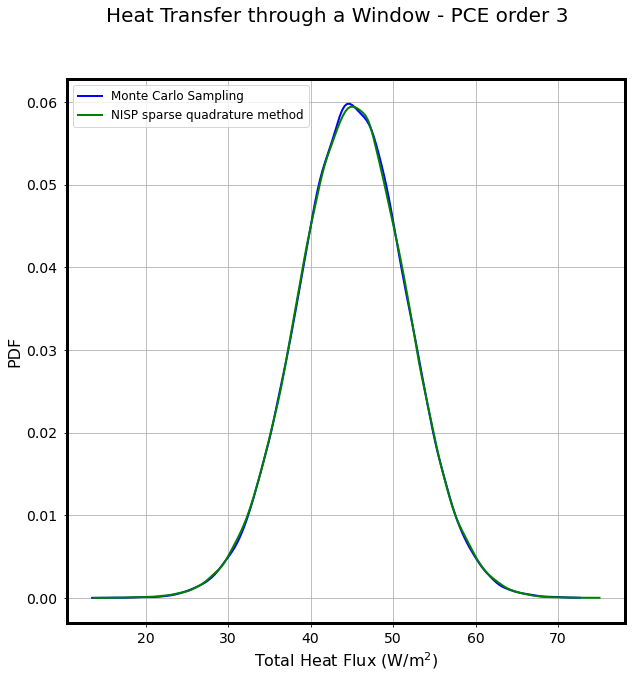

In [17]:
plt.figure(figsize=(10,10))
if not (tooManyPts):
    plt.plot(xpts_pce, PDF_data_pce, linewidth=2, color='r', label='NISP full quadrature method')
plt.plot(xpts_MC, PDF_data_MC, linewidth=2, color='b', label='Monte Carlo Sampling')
plt.plot(xpts_pce2, PDF_data_pce2, linewidth=2, color='g', label= 'NISP sparse quadrature method')

# Label axes
plt.xlabel("Total Heat Flux ($W/m^2$)", size=16)
plt.ylabel("PDF", size=16)
# Add title
plt.suptitle("Heat Transfer through a Window - PCE order %s"%(nord), size=20)
# Change tick size
plt.tick_params(axis='both', labelsize=14)
# Pad tick labels
plt.gca().tick_params(pad=6)
# Create legend
plt.legend(loc='upper left', prop={'size':12})
# Show figure
plt.show()

For the PC methods, these plots show the spectral decay of the PC coefficient magnitude in relation to PC order for both full and sparse quadrature.

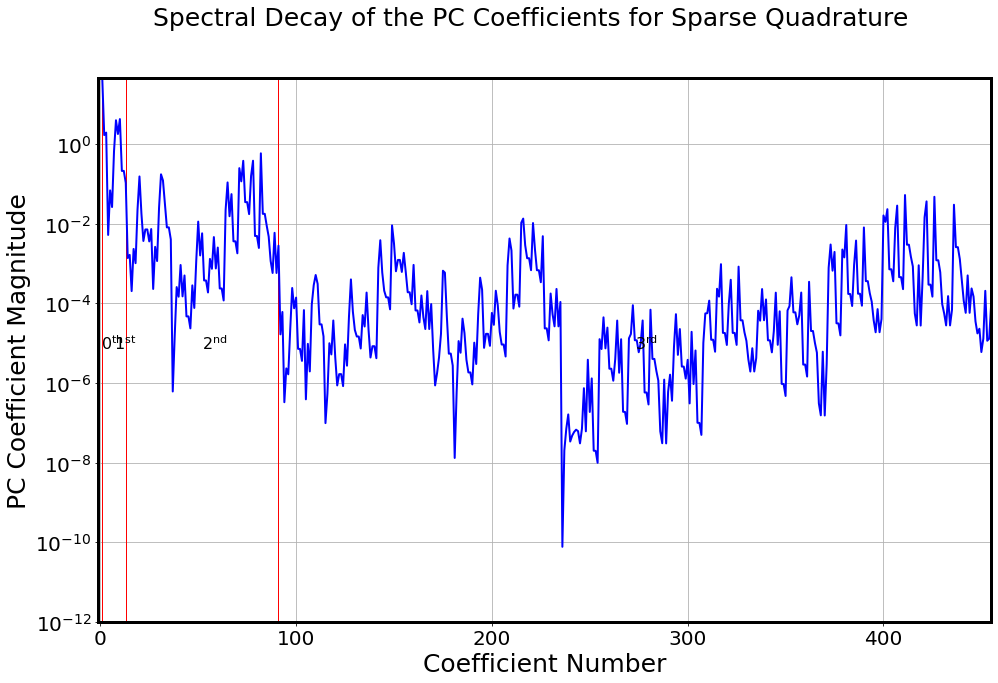

In [18]:
if not(tooManyPts):
    pce_tools.UQTkPlotMiDims(pc_model,c_k,ndim, nord, "Full")
pce_tools.UQTkPlotMiDims(pc_model2,c_k2,ndim, nord, "Sparse")